In [53]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import glob
import seaborn as sns

from PIL import Image
from scipy import ndimage


from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix

from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model
from keras.optimizers import RMSprop

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC
from sklearn.utils import compute_class_weight



%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
batch_size = 64
target_size = (176, 208)

train_dir = '../../src/data/train'
test_dir = '../../src/data/test'

# Validation_split was .2 for all models besides RMS_model4.
dagenerator = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator  = dagenerator.flow_from_directory(directory = train_dir,
                                                   target_size = target_size,
                                                   subset = 'training',
                                                   color_mode="grayscale", #Graysacle only ran on RMS_model4. All other used rgb
                                                   batch_size = batch_size)

val_generator = dagenerator.flow_from_directory(directory = train_dir,
                                                  target_size = target_size,
                                                  subset = 'validation',
                                                  color_mode="grayscale", #Graysacle only ran on RMS_model4. All other used rgb
                                                  shuffle = False,
                                                  batch_size = batch_size)

# class imbalance shown on 
class_weights = compute_class_weight('balanced', np.unique(train_generator.classes), train_generator.classes)
dict_class_weights = dict(enumerate(class_weights));
print(f' Class weights: {dict_class_weights}');

Found 4610 images belonging to 4 classes.
Found 511 images belonging to 4 classes.
 Class weights: {0: 1.7840557275541795, 1: 24.52127659574468, 2: 0.5002170138888888, 3: 0.7145071295722256}


### class imbalance shown on EDA notebook in original_exploratory folder
With 20% validation set

 Train Mild: 574 <br>
 Train Moderate: 41<br>
 Train Normal: 2049<br>
 Train Very Mild: 1434<br>
 
 Val Mild: 144<br>
 Val Moderate: 11<br>
 Val Normal: 512<br>
 Val Very Mild: 359<br>
 
 Test Mild: 179<br>
 Test Moderate: 12<br>
 Test Normal: 640<br>
 Test Very Mild: 448<br>


In [4]:
#model 1
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(8, activation='relu'))
model.add(Dropout(.25))
model.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify


model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics= ['acc', 'AUC'])




# Fit parameters 

earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 20,
                              verbose = 1)

filepath = '../../src/best_weights_adam.hdf5'
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callbacks = [earlystopping, checkpoint]


epochs = 200
steps_per_epoch = train_generator.n // batch_size
validation_steps = val_generator.n // batch_size


history = model.fit_generator(
        generator =train_generator,
        steps_per_epoch = steps_per_epoch,
        validation_data = val_generator,
        validation_steps = validation_steps,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 1.4658 - acc: 0.4056 - auc: 0.6439
Epoch 00001: val_acc improved from -inf to 0.30729, saving model to ../../src/best_weights_adam.hdf5
64/64 [==============================] - 129s 2s/step - loss: 1.4658 - acc: 0.4056 - auc: 0.6439 - val_loss: 1.3822 - val_acc: 0.3073 - val_auc: 0.5672
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 1.3934 - acc: 0.3443 - auc: 0.6107
Epoch 00002: val_acc did not improve from 0.30729
64/64 [==============================] - 126s 2s/step - loss: 1.3934 - acc: 0.3443 - auc: 0.6107 - val_loss: 1.3836 - val_acc: 0.3073 - val_auc: 0.5000
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 1.3834 - acc: 0.3857 - auc: 0.6126
Epoch 00003: val_acc did not improve from 0.30729
64/64 [==============================] - 124s 2s/step - loss: 1.3834 - acc: 0.3857 - auc: 0.6126 - val_loss

In [5]:
#model 1
model_RMS = Sequential()

model_RMS.add(Conv2D(32, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model_RMS.add(MaxPooling2D((2,2)))
model_RMS.add(Conv2D(64, (3, 3), activation='relu'))
model_RMS.add(MaxPooling2D((2, 2)))
model_RMS.add(Conv2D(128, (3, 3), activation='relu'))
model_RMS.add(Flatten())
model_RMS.add(Dense(64, activation='relu'))
model_RMS.add(Dropout(.5))
model_RMS.add(Dense(16, activation='relu'))
model_RMS.add(Dropout(.5))
model_RMS.add(Dense(8, activation='relu'))
model_RMS.add(Dropout(.25))
model_RMS.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify


model_RMS.compile(loss='categorical_crossentropy', 
              optimizer='RMSprop',
              metrics= ['acc', 'AUC'])




# Fit parameters 

earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 25,
                              verbose = 1)

filepath = '../../src/best_weights_RMS.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callbacks = [earlystopping, checkpoint]

epochs = 200
steps_per_epoch = train_generator.n // batch_size
validation_steps = val_generator.n // batch_size


history_RMS = model_RMS.fit_generator(
        generator =train_generator,
        steps_per_epoch = steps_per_epoch,
        validation_data = val_generator,
        validation_steps = validation_steps,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=epochs)

Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 1.6885 - acc: 0.3195 - auc: 0.6048
Epoch 00001: val_acc improved from -inf to 0.30729, saving model to ../../src/best_weights_RMS.hdf5
64/64 [==============================] - 123s 2s/step - loss: 1.6885 - acc: 0.3195 - auc: 0.6048 - val_loss: 1.3802 - val_acc: 0.3073 - val_auc: 0.7079
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 1.4104 - acc: 0.2452 - auc: 0.5463
Epoch 00002: val_acc did not improve from 0.30729
64/64 [==============================] - 127s 2s/step - loss: 1.4104 - acc: 0.2452 - auc: 0.5463 - val_loss: 1.3979 - val_acc: 0.2896 - val_auc: 0.3254
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 1.4358 - acc: 0.2315 - auc: 0.5534
Epoch 00003: val_acc improved from 0.30729 to 0.52812, saving model to ../../src/best_weights_RMS.hdf5
64/64 [==============================] - 146s 2s/step - loss: 1.4358 - acc: 0.2315 - auc: 0.5534 - val_loss: 1.2774 - val_acc: 0.52

In [6]:
model_RMS2 = Sequential()

model_RMS2.add(Conv2D(16, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model_RMS2.add(MaxPooling2D((2,2)))
model_RMS2.add(Conv2D(32, (3, 3), activation='relu'))
model_RMS2.add(MaxPooling2D((2, 2)))
model_RMS2.add(Conv2D(32, (3, 3), activation='relu'))
model_RMS2.add(Flatten())
model_RMS2.add(Dense(32, activation='relu'))
model_RMS2.add(Dropout(.25))
model_RMS2.add(Dense(16, activation='relu'))
model_RMS2.add(Dropout(.25))
model_RMS2.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify


model_RMS2.compile(loss='categorical_crossentropy', 
              optimizer='RMSprop',
              metrics= ['acc', 'AUC'])

# Fit parameters 

earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 25,
                              verbose = 1)

filepath = '../../src/best_weights_RMS2.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callbacks = [earlystopping, checkpoint]

epochs = 200
steps_per_epoch = train_generator.n // batch_size
validation_steps = val_generator.n // batch_size


history_RMS2 = model_RMS2.fit_generator(
        generator =train_generator,
        steps_per_epoch = steps_per_epoch,
        validation_data = val_generator,
        validation_steps = validation_steps,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=epochs)

Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 1.4298 - acc: 0.3575 - auc: 0.6465
Epoch 00001: val_acc improved from -inf to 0.17083, saving model to ../../src/best_weights_RMS2.hdf5
64/64 [==============================] - 49s 772ms/step - loss: 1.4298 - acc: 0.3575 - auc: 0.6465 - val_loss: 1.4011 - val_acc: 0.1708 - val_auc: 0.3944
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 1.3781 - acc: 0.4239 - auc: 0.7084
Epoch 00002: val_acc improved from 0.17083 to 0.33229, saving model to ../../src/best_weights_RMS2.hdf5
64/64 [==============================] - 49s 764ms/step - loss: 1.3781 - acc: 0.4239 - auc: 0.7084 - val_loss: 1.4251 - val_acc: 0.3323 - val_auc: 0.4830
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 1.2813 - acc: 0.4427 - auc: 0.7286
Epoch 00003: val_acc did not improve from 0.33229
64/64 [==============================] - 49s 764ms/step - loss: 1.2813 - acc: 0.4427 - auc: 0.7286 - val_loss: 1.3444 - val_a

In [7]:
model_RMS3 = Sequential()

model_RMS3.add(Conv2D(8, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model_RMS3.add(MaxPooling2D((2,2)))
model_RMS3.add(Conv2D(16, (3, 3), activation='relu'))
model_RMS3.add(MaxPooling2D((2, 2)))
model_RMS3.add(Conv2D(32, (3, 3), activation='relu'))
model_RMS3.add(Flatten())
model_RMS3.add(Dense(16, activation='relu'))
model_RMS3.add(Dropout(.25))
model_RMS3.add(Dense(8, activation='relu'))
model_RMS3.add(Dropout(.25))
model_RMS3.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify


model_RMS3.compile(loss='categorical_crossentropy', 
              optimizer='RMSprop',
              metrics= ['acc', 'AUC'])

# Fit parameters 

earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 25,
                              verbose = 1)

filepath = '../../src/best_weights_RMS3.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callbacks = [earlystopping, checkpoint]

epochs = 200
steps_per_epoch = train_generator.n // batch_size
validation_steps = val_generator.n // batch_size


history_RMS3 = model_RMS3.fit_generator(
        generator =train_generator,
        steps_per_epoch = steps_per_epoch,
        validation_data = val_generator,
        validation_steps = validation_steps,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=epochs)

Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 1.4546 - acc: 0.4244 - auc: 0.5753
Epoch 00001: val_acc improved from -inf to 0.53333, saving model to ../../src/best_weights_RMS3.hdf5
64/64 [==============================] - 30s 469ms/step - loss: 1.4546 - acc: 0.4244 - auc: 0.5753 - val_loss: 1.3789 - val_acc: 0.5333 - val_auc: 0.6889
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 1.3916 - acc: 0.4998 - auc: 0.6817
Epoch 00002: val_acc did not improve from 0.53333
64/64 [==============================] - 30s 464ms/step - loss: 1.3916 - acc: 0.4998 - auc: 0.6817 - val_loss: 1.3781 - val_acc: 0.5333 - val_auc: 0.6710
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 1.3822 - acc: 0.5002 - auc: 0.6573
Epoch 00003: val_acc did not improve from 0.53333
64/64 [==============================] - 30s 463ms/step - loss: 1.3822 - acc: 0.5002 - auc: 0.6573 - val_loss: 1.3762 - val_acc: 0.5333 - val_auc: 0.6710
Epoch 4/200
64/64 [======

In [8]:
model_adam2 = Sequential()

model_adam2.add(Conv2D(8, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model_adam2.add(MaxPooling2D((2,2)))
model_adam2.add(Conv2D(16, (3, 3), activation='relu'))
model_adam2.add(MaxPooling2D((2, 2)))
model_adam2.add(Conv2D(32, (3, 3), activation='relu'))
model_adam2.add(Flatten())
model_adam2.add(Dense(16, activation='relu'))
model_adam2.add(Dropout(.25))
model_adam2.add(Dense(8, activation='relu'))
model_adam2.add(Dropout(.25))
model_adam2.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify


model_adam2.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics= ['acc', 'AUC'])

# Fit parameters 

earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 25,
                              verbose = 1)

filepath = '../../src/best_weights_adam2.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callbacks = [earlystopping, checkpoint]

epochs = 200
steps_per_epoch = train_generator.n // batch_size
validation_steps = val_generator.n // batch_size


history_adam2 = model_adam2.fit_generator(
        generator =train_generator,
        steps_per_epoch = steps_per_epoch,
        validation_data = val_generator,
        validation_steps = validation_steps,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=epochs)

Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 1.4179 - acc: 0.2600 - auc: 0.4123
Epoch 00001: val_acc improved from -inf to 0.53333, saving model to ../../src/best_weights_adam2.hdf5
64/64 [==============================] - 31s 483ms/step - loss: 1.4179 - acc: 0.2600 - auc: 0.4123 - val_loss: 1.3713 - val_acc: 0.5333 - val_auc: 0.7878
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 1.3846 - acc: 0.5007 - auc: 0.7502
Epoch 00002: val_acc did not improve from 0.53333
64/64 [==============================] - 30s 467ms/step - loss: 1.3846 - acc: 0.5007 - auc: 0.7502 - val_loss: 1.3739 - val_acc: 0.5333 - val_auc: 0.7502
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 1.3894 - acc: 0.5005 - auc: 0.7511
Epoch 00003: val_acc did not improve from 0.53333
64/64 [==============================] - 30s 474ms/step - loss: 1.3894 - acc: 0.5005 - auc: 0.7511 - val_loss: 1.3761 - val_acc: 0.5333 - val_auc: 0.7502
Epoch 4/200
63/64 [=====

In [9]:
model_sgd = Sequential()

model_sgd.add(Conv2D(32, (3,3), activation='relu', input_shape = (target_size[0],target_size[1],3)))
model_sgd.add(MaxPooling2D((2,2)))
model_sgd.add(Conv2D(64, (3, 3), activation='relu'))
model_sgd.add(MaxPooling2D((2, 2)))
model_sgd.add(Conv2D(128, (3, 3), activation='relu'))
model_sgd.add(Flatten())
model_sgd.add(Dense(64, activation='relu'))
model_sgd.add(Dropout(.5))
model_sgd.add(Dense(16, activation='relu'))
model_sgd.add(Dropout(.5))
model_sgd.add(Dense(8, activation='relu'))
model_sgd.add(Dropout(.25))
model_sgd.add(Dense(4, activation='softmax')) # last layer has to match the amount of catagories trying to classify



model_sgd.compile(loss='categorical_crossentropy', 
              optimizer='sgd',
              metrics= ['acc', 'AUC'])

# Fit parameters 

earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 25,
                              verbose = 1)

filepath = '../../src/best_weights_sgd.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callbacks = [earlystopping, checkpoint]

epochs = 200
steps_per_epoch = train_generator.n // batch_size
validation_steps = val_generator.n // batch_size


history_sgd = model_sgd.fit_generator(
        generator =train_generator,
        steps_per_epoch = steps_per_epoch,
        validation_data = val_generator,
        validation_steps = validation_steps,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=epochs)

Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 1.4017 - acc: 0.2635 - auc: 0.5196
Epoch 00001: val_acc improved from -inf to 0.30729, saving model to ../../src/best_weights_sgd.hdf5
64/64 [==============================] - 109s 2s/step - loss: 1.4017 - acc: 0.2635 - auc: 0.5196 - val_loss: 1.3754 - val_acc: 0.3073 - val_auc: 0.6519
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 1.3965 - acc: 0.2310 - auc: 0.5165
Epoch 00002: val_acc improved from 0.30729 to 0.53333, saving model to ../../src/best_weights_sgd.hdf5
64/64 [==============================] - 109s 2s/step - loss: 1.3965 - acc: 0.2310 - auc: 0.5165 - val_loss: 1.3778 - val_acc: 0.5333 - val_auc: 0.6830
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 1.3835 - acc: 0.2826 - auc: 0.5515
Epoch 00003: val_acc did not improve from 0.53333
64/64 [==============================] - 110s 2s/step - loss: 1.3835 - acc: 0.2826 - auc: 0.5515 - val_loss: 1.3793 - val_acc: 0.53

# Models using RMS performed a lot better and were able to converge

In [14]:
# importing the two models that performed the best
model_RMS = load_model('../../src/best_weights_RMS.hdf5')
model_RMS2 = load_model('../../src/best_weights_RMS2.hdf5')

-----------------------Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.85      0.65      0.74       143
    Moderate       1.00      0.80      0.89        10
        None       0.87      0.79      0.83       512
   Very Mild       0.67      0.82      0.73       358

    accuracy                           0.78      1023
   macro avg       0.85      0.77      0.80      1023
weighted avg       0.80      0.78      0.79      1023

------------------------Confusion Matrix---------------------------


array([0, 0, 0, ..., 3, 2, 3])

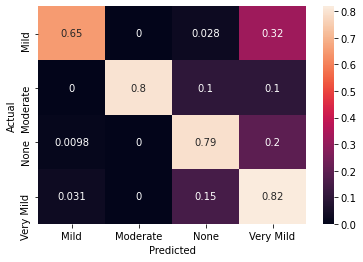

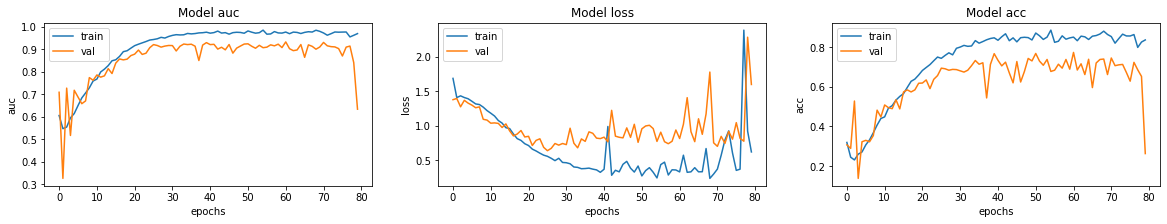

In [38]:
from src.mymods import Vis_results
Vis_results(model_RMS, history_RMS, val_generator, val_generator.n, batch_size )

In [70]:
dagenerator_test = ImageDataGenerator(rescale=1./255)
num_of_test_samples = len(glob.glob('../../src/data/test/*/*.jpg'))

test_generator  = dagenerator_test.flow_from_directory(directory = test_dir,
                                                   target_size = target_size,
                                                   color_mode="grayscale",
                                                   batch_size = len(glob.glob('../../src/data/test/*/*.jpg')),
                                                   shuffle = False )

Found 1282 images belonging to 4 classes.


In [44]:
model_RMS.evaluate_generator(test_generator)

[4.683191776275635, 0.6028146743774414, 0.7740604877471924]

-----------------------Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.73      0.20      0.32       179
    Moderate       1.00      0.08      0.15        12
        None       0.64      0.77      0.70       640
   Very Mild       0.53      0.54      0.53       448

    accuracy                           0.60      1279
   macro avg       0.73      0.40      0.43      1279
weighted avg       0.62      0.60      0.58      1279

------------------------Confusion Matrix---------------------------


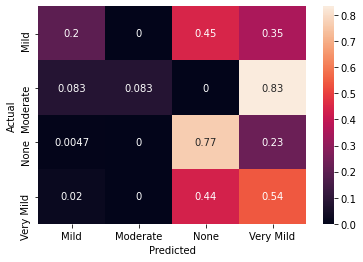

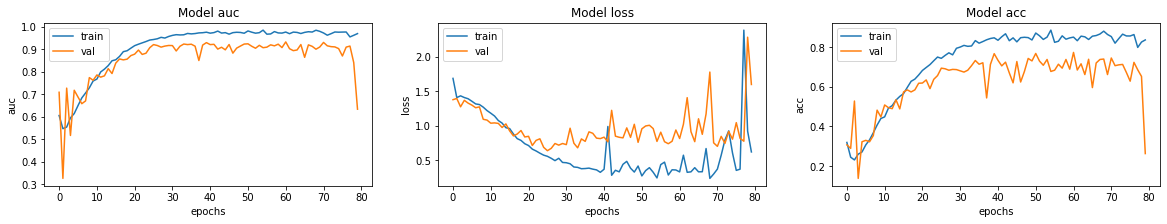

In [35]:
Vis_results(model_RMS, history_RMS, test_generator, num_of_test_samples, batch_size )

-----------------------Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.71      0.88      0.79       143
    Moderate       1.00      1.00      1.00        10
        None       0.77      0.92      0.84       512
   Very Mild       0.86      0.53      0.65       358

    accuracy                           0.78      1023
   macro avg       0.83      0.83      0.82      1023
weighted avg       0.79      0.78      0.77      1023

------------------------Confusion Matrix---------------------------


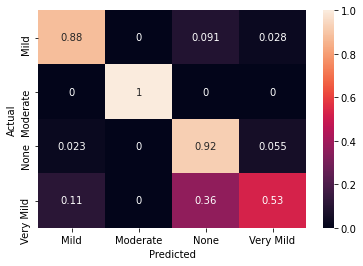

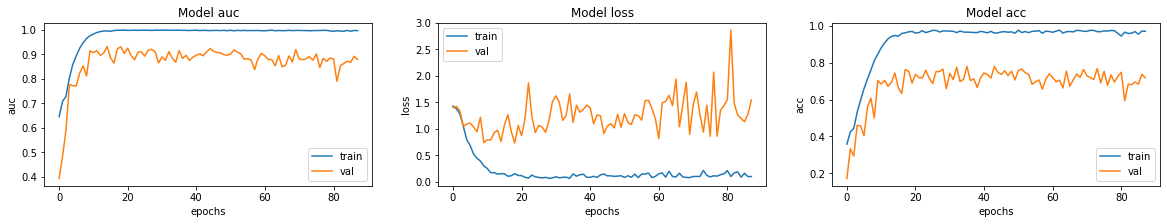

In [36]:
Vis_results(model_RMS2, history_RMS2, val_generator, val_generator.n, batch_size)

-----------------------Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.88      0.12      0.22       179
    Moderate       1.00      0.17      0.29        12
        None       0.60      0.87      0.71       640
   Very Mild       0.62      0.43      0.51       448

    accuracy                           0.61      1279
   macro avg       0.77      0.40      0.43      1279
weighted avg       0.65      0.61      0.56      1279

------------------------Confusion Matrix---------------------------


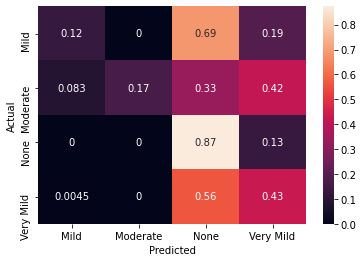

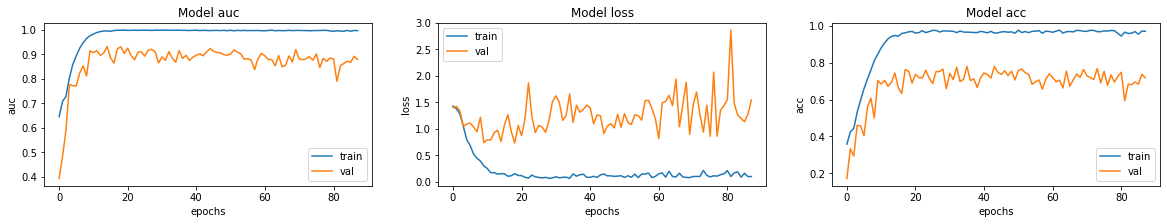

In [39]:
test_pred_RMS2 = Vis_results(model_RMS2, history_RMS2, test_generator, test_generator.n, batch_size)

In [64]:
import sys
import numpy
numpy.set_printoptions(threshold=1000)
test_pred_RMS2

array([0, 0, 0, ..., 2, 2, 2])

In [42]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
model_RMS4.add

In [69]:
model_RMS4 = Sequential()

model_RMS4.add(Conv2D(64,(5,5), activation = 'relu', padding = 'same',
               strides=(2,2), input_shape = (target_size[0],target_size[1],1)))
model_RMS4.add(MaxPooling2D(2))
model_RMS4.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model_RMS4.add(Conv2D(128,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model_RMS4.add(Conv2D(256,(5,5), activation = 'relu', padding = 'same', strides=(2,2)))
model_RMS4.add(MaxPooling2D(2))
model_RMS4.add(Flatten())
model_RMS4.add(Dense(64, activation = 'relu'))
model_RMS4.add(Dropout(0.4))
model_RMS4.add(Dense(32, activation = 'relu'))
model_RMS4.add(Dropout(0.4))
model_RMS4.add(Dense(4, activation = 'softmax'))
               
               
model_RMS4.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(learning_rate = 1e-4),
              metrics= ['acc', 'AUC'])

# Fit parameters 

earlystopping = EarlyStopping(monitor = 'acc', 
                              mode = 'max' , 
                              patience = 15,
                              restore_best_weights= True,
                              verbose = 1)

filepath = '../../src/best_weights_RMS4.hdf5'
checkpoint = ModelCheckpoint(filepath, 
                                monitor = 'val_acc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callbacks = [earlystopping, checkpoint]

epochs = 100
steps_per_epoch = train_generator.n // batch_size
validation_steps = val_generator.n // batch_size


history_RMS4 = model_RMS4.fit_generator(
        generator =train_generator,
        steps_per_epoch = steps_per_epoch,
        validation_data = val_generator,
        validation_steps = validation_steps,
        class_weight = dict_class_weights,
        callbacks = callbacks, 
        epochs=epochs)

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 1.4001 - acc: 0.2411 - auc: 0.5391
Epoch 00001: val_acc improved from -inf to 0.15848, saving model to ../../src/best_weights_RMS4.hdf5
72/72 [==============================] - 79s 1s/step - loss: 1.4001 - acc: 0.2411 - auc: 0.5391 - val_loss: 1.3811 - val_acc: 0.1585 - val_auc: 0.5227
Epoch 2/100
72/72 [==============================] - ETA: 0s - loss: 1.3935 - acc: 0.2818 - auc: 0.5434
Epoch 00002: val_acc improved from 0.15848 to 0.25893, saving model to ../../src/best_weights_RMS4.hdf5
72/72 [==============================] - 96s 1s/step - loss: 1.3935 - acc: 0.2818 - auc: 0.5434 - val_loss: 1.3744 - val_acc: 0.2589 - val_auc: 0.5572
Epoch 3/100
72/72 [==============================] - ETA: 0s - loss: 1.3872 - acc: 0.2261 - auc: 0.5470
Epoch 00003: val_acc did not improve from 0.25893
72/72 [==============================] - 92s 1s/step - loss: 1.3872 - acc: 0.2261 - auc: 0.5470 - val_loss: 1.3775 - val_acc: 0.158

In [72]:
model_RMS4 = load_model('../../src/best_weights_RMS4.hdf5')

-----------------------Classification Report-------------------
              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00        71
    Moderate       1.00      1.00      1.00         5
        None       1.00      1.00      1.00       256
   Very Mild       1.00      1.00      1.00       179

    accuracy                           1.00       511
   macro avg       1.00      1.00      1.00       511
weighted avg       1.00      1.00      1.00       511

------------------------Confusion Matrix---------------------------


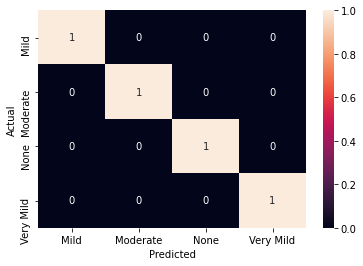

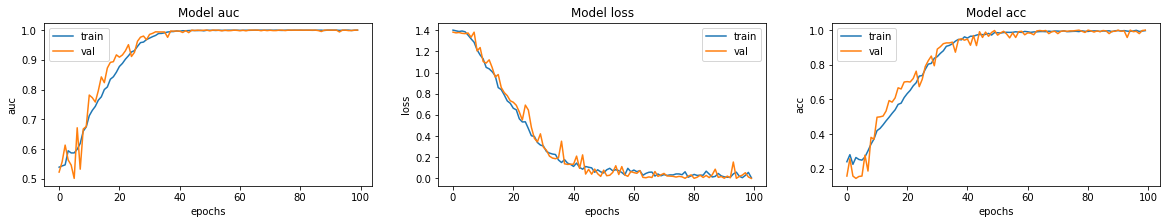

In [78]:
val_preds_RMS4 = Vis_results(model_RMS4, history_RMS4, val_generator, val_generator.n, batch_size)

-----------------------Classification Report-------------------
              precision    recall  f1-score   support

        Mild       0.85      0.26      0.40       179
    Moderate       0.80      0.27      0.40        15
        None       0.84      0.36      0.51       640
   Very Mild       0.45      0.96      0.61       448

    accuracy                           0.56      1282
   macro avg       0.74      0.46      0.48      1282
weighted avg       0.71      0.56      0.53      1282

------------------------Confusion Matrix---------------------------


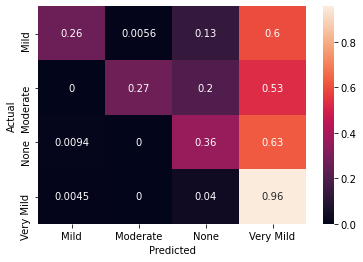

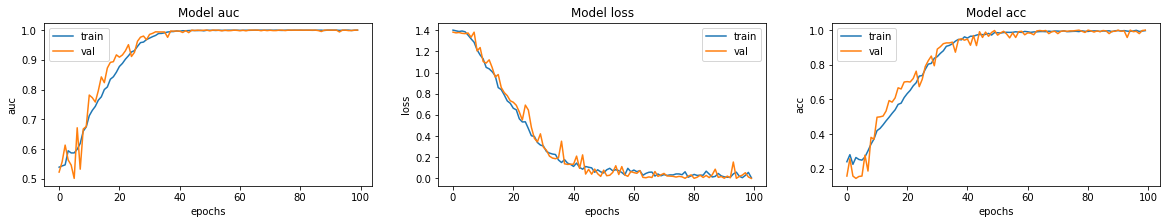

In [76]:
test_preds_RMS4 = Vis_results(model_RMS4, history_RMS4, test_generator, test_generator.n, batch_size)

In [77]:
test_preds_RMS4

array([0, 0, 0, ..., 2, 2, 3])